In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Extrapolation in temperature

In [2]:
#Import idealgas module
from thermoextrap import idealgas

#Define test betas and reference beta
betas = np.arange(0.1, 10.0, 0.5)
beta_ref = betas[11]
vol = 1.0

#Define orders to extrapolate to
orders = [1,2,4,6]
order = orders[-1]

npart = 1000 #Number of particles (in single configuration)
nconfig = 100_000 #Number of configurations

#Generate all the data we could want
xdata, udata = idealgas.generate_data((nconfig, npart), beta_ref, vol)

## Case 1: Observable is an average with no explicit dependence on temperature

We first extrapolate our ideal gas test system in temperature and compare to the exact result. We also compare results with finite numbers of samples to exact results for an infinite number of samples. This is possible because we can analytically calculate derivatives for the ideal gas model at any order rather than estimating them.

The first thing we want to do is define some parameters and generate data. We will define a reference inverse temperature, specific orders we want to extrapolate to, and create some reference data. The `generate_data` function of the `idealgas` module conveniently provides random samples of $x$ and $U$ data. This will be in the format of an array with `nconfig` elements, each being the average $x$ value over $N$ independent ideal gas particles. The relevant potential energy is an array of the same shape with a single entry for each configuration. More generally, the data that should be provided to the extrapolation/interpolation code can have any number of columns but should have a single row associated with each simulation snapshot and potential energy. This allows for simultaneous extrapolation of all points in RDFs or time correlation functions with the interparticle distance or time varying with column. Or for simultaneous extrapolation of multiple observables. Critical, however, is that the potential energy (or Hamiltonian) is that which is appropriate to the snapshot with the same index. So for dynamical quantities like time correlation functions, the appropriate Hamiltonian is that for the starting configuration. Another main point here is that the number of columns is arbitrary, with each extrapolated separately, but because of the way the code is vectorized you get much better efficiency by providing multiple columns rather than running the extrapolation multiple times for different observables.

For more information on the structure of data and other options for inputing data, please see the "Data_Organization" notebook.

All the code below relys on inputting xarray objects. This is easily applied.

In [3]:
import xarray as xr

xdata = xr.DataArray(xdata, dims=['rec'])
udata = xr.DataArray(udata, dims=['rec'])

We now want to create and train our extrapolation and perturbation models that we will compare. By default the `ExtrapModel` or other classes work with the simplest case of directly extrapolating an observable that is an average quantity and does not explicitly depend on temperature. Note that this covers quantities that include dependence on kinetic degrees of freedom, with the potential energy simply substituted for the full Hamiltonian (total energy). Or it works for extrapolating in temperature or pressure in the NPT ensemble - again you just have to insert the appropriate Hamiltonian instead of the potential energy. To be specific, that means that if we want to extrapolate with respect to $\beta$ in the NPT ensemble, we need to provide $U + pV$ instead of just $U$. To extrapolate with respect to $p$ in the NPT, we only provide $\beta V$ at each snapshot. The math then works out the same way and all of this code can be re-used. We handle other cases, like explicit temperature dependence of the quantity to be averaged, in other notebooks.

In [4]:
import thermoextrap as xtrap

In [5]:
# First, create a model around the data - see "Data_Organization" notebook
data = xtrap.DataCentralMomentsVals.from_vals(order=orders[-1], 
                                                  rec_dim='rec',
                                                  xv=xdata, uv=udata, central=True)

# Create extrapolation and perturbation models
xem = xtrap.beta.factory_extrapmodel(beta_ref, data)
xpm = xtrap.beta.factory_perturbmodel(beta_ref, uv=udata, xv=xdata)

Let's test some predictions and look at the results. Notice that you can make predictions over scalars or arrays of values, but the extrapolation will only be 1D in the variable of interest (e.g. temperature, pressure, etc.). Extrapolations in multiple dimensions of state variables is not yet supported.

In [6]:
#Make some predictions
print("Extrapolation prediction:\n", xem.predict(betas[0]).values)
print("Perturbation prediction:\n", xpm.predict(betas[0]).values)
print('\n')

#By default, uses maximum order, which here is innacurate due to limited sampling (see figure below)
#But can switch to any lower order if desired
#Remember, order doesn't matter for perturbation
print("At lower order...")
print("Extrapolation:\n", xem.predict(betas[0], order=2).values)
print("Perturbation:\n", xpm.predict(betas[0]).values)
print('\n')

#Can also make predictions for multiple values
print("For multiple beta values...")
print("Extrapolation:")
print(xem.predict(betas[:4], order=2).values)
print("Perturbation:")
print(xpm.predict(betas[:4]).values)



Extrapolation prediction:
 -778.0763716443079
Perturbation prediction:
 0.19952676942588934


At lower order...
Extrapolation:
 0.4678345956678327
Perturbation:
 0.19952676942588934


For multiple beta values...
Extrapolation:
[0.4678346  0.42973823 0.39393414 0.36042233]
Perturbation:
[0.19952677 0.19952652 0.1995259  0.19952436]


All of the extrapolation/interpolation model classes come with a way to resample data efficiently to allow for bootstrapped uncertainty estimates. The `resample` function actually resamples the data and returns a new extrapolation/interpolation class object, meaning that the necessary coefficients are automatically recomputed. However, the coefficients are computed separately for the different bootstrapped samples, which appear as different entires in the "replication" or "rep" dimension. In what we show below, this makes it easy to create bootstrap resampled data, then compute statistics on the coefficients or the predictions using built in statistical functions in xarray (e.g., `.mean()` and `.std()`).

In [7]:
# Create a bootstrapped sample
boot_xem = xem.resample(nrep=100)

# Predict coefficients - these are derivatives divided by appropriate factorial, so Taylor series coefficients
boot_xem.coefs(order=2)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<xarray.DataArray (order: 3, rep: 100)>
array([[ 0.17486701,  0.174849  ,  0.17483941,  0.17482911,  0.17485644,
         0.17486133,  0.17483915,  0.17483634,  0.17483938,  0.17487609,
         0.17484701,  0.17485064,  0.17484434,  0.17485212,  0.1748745 ,
         0.17484745,  0.17486069,  0.17485356,  0.17484473,  0.17483432,
         0.17486152,  0.17482664,  0.17485221,  0.17485329,  0.17484861,
         0.17483688,  0.1748566 ,  0.17486529,  0.17486266,  0.17484051,
         0.17482844,  0.17486056,  0.17482183,  0.17487689,  0.17484163,
         0.1748604 ,  0.17485817,  0.17484413,  0.17486561,  0.17485903,
         0.17483013,  0.17486107,  0.17485091,  0.17485611,  0.17483373,
         0.17487212,  0.17485546,  0.17485552,  0.17486593,  0.17482805,
         0.17488981,  0.17484135,  0.17485299,  0.17484258,  0.17485112,
         0.17485189,  0.17480449,  0.17483891,  0.17483092,  0.17485307,
         0.17482573,  0.17485067,  0.17485217,  0.17484912,  0.17484445,
         0.17487803,  0.17486733,  0.17485227,  0.17484813,  0.1748588 ,
         0.17486271,  0.17483355,  0.17483994,  0.17485956,  0.17486357,
         0.17484886,  0.17486191,  0.17484169,  0.17484989,  0.17483815,
         0.17486236,  0.17485968,  0.17486754,  0.17483955,  0.17482534,
         0.17483448,  0.1748526 ,  0.17485242,  0.17485694,  0.17486821,
         0.1748697 ,  0.17489174,  0.17483975,  0.17488365,  0.17485577,
         0.17482304,  0.17485941,  0.17485277,  0.17484821,  0.17481392],
...
       [ 0.0032917 ,  0.00546257,  0.00530036,  0.00465102,  0.00350233,
         0.00360782,  0.00471654,  0.00427158,  0.00385788,  0.00376559,
         0.00469448,  0.00530946,  0.0039683 ,  0.00479755,  0.00457353,
         0.00435862,  0.00526084,  0.00389493,  0.00395668,  0.00409468,
         0.00529836,  0.00353   ,  0.00397242,  0.0046688 ,  0.0042902 ,
         0.00388139,  0.00466756,  0.00523548,  0.00417051,  0.00407097,
         0.00538322,  0.00468334,  0.00442396,  0.00437023,  0.00484997,
         0.0046274 ,  0.00459534,  0.00502389,  0.00429954,  0.00361406,
         0.00495671,  0.00416116,  0.00371135,  0.00507076,  0.00473676,
         0.00500413,  0.00460342,  0.0048463 ,  0.00402477,  0.00508634,
         0.00577308,  0.00468854,  0.0041549 ,  0.00499486,  0.00530715,
         0.0032467 ,  0.00517307,  0.00462045,  0.00408818,  0.0040877 ,
         0.00397776,  0.00420128,  0.00399643,  0.00463295,  0.0045991 ,
         0.00424324,  0.0039978 ,  0.0044287 ,  0.00469204,  0.0041184 ,
         0.00465386,  0.00373934,  0.00371738,  0.00462565,  0.00448575,
         0.00332942,  0.00361379,  0.00437579,  0.00422442,  0.00536317,
         0.00486444,  0.00406966,  0.00426938,  0.00414541,  0.00435037,
         0.00462784,  0.00479024,  0.00338552,  0.00451149,  0.00587663,
         0.00423677,  0.00484151,  0.00366938,  0.00416613,  0.00614481,
         0.00368836,  0.00475638,  0.00461603,  0.00514358,  0.00354095]])
Dimensions without coordinates: order, rep

In [8]:
# Make predictions
boot_xem.predict(betas[:4], order=2)

<xarray.DataArray (beta: 4, rep: 100)>
array([[0.42872284, 0.49515743, 0.48783359, 0.46961029, 0.43291587,
        0.43838508, 0.47361605, 0.45834071, 0.44631039, 0.44273121,
        0.47203857, 0.48909814, 0.44856641, 0.47442652, 0.4668737 ,
        0.4604109 , 0.48743544, 0.44652249, 0.44931078, 0.45435682,
        0.48905445, 0.43558023, 0.44923774, 0.47038375, 0.4603855 ,
        0.44578549, 0.46933493, 0.48756672, 0.45559718, 0.45178268,
        0.492298  , 0.47131151, 0.46291616, 0.46075471, 0.47482635,
        0.47014462, 0.46739203, 0.48135315, 0.45872059, 0.43869467,
        0.47827645, 0.45473316, 0.44083961, 0.48379383, 0.47191506,
        0.4805155 , 0.46813275, 0.47580417, 0.45073406, 0.48187099,
        0.50440464, 0.46975889, 0.4550219 , 0.48088113, 0.4889785 ,
        0.42676931, 0.48519523, 0.46941142, 0.45241822, 0.45323911,
        0.45065458, 0.45706108, 0.45111229, 0.4692603 , 0.46948695,
        0.4574106 , 0.44987987, 0.46267311, 0.47214523, 0.45296283,
        0.47112874, 0.44256757, 0.4421024 , 0.46966511, 0.46497601,
        0.42897516, 0.43834234, 0.46160973, 0.45731536, 0.49063266,
        0.47562949, 0.45241269, 0.45771718, 0.45455328, 0.46214694,
        0.46941208, 0.47357577, 0.43225115, 0.46572347, 0.5066708 ,
        0.45692929, 0.47459852, 0.44012142, 0.45581704, 0.51531091,
        0.43990313, 0.47283788, 0.46981584, 0.48520123, 0.43614979],
...
       [0.33973923, 0.37502519, 0.37066936, 0.36130929, 0.34152207,
        0.34486807, 0.36383219, 0.35539185, 0.34912557, 0.3470863 ,
        0.36281946, 0.3715375 , 0.35010513, 0.3639391 , 0.35979636,
        0.35637823, 0.37062274, 0.34906136, 0.35071633, 0.35355535,
        0.37157533, 0.34328561, 0.35057079, 0.36177172, 0.3567706 ,
        0.34860209, 0.3610173 , 0.37087165, 0.35401018, 0.35182717,
        0.37341606, 0.36236121, 0.3578012 , 0.35656663, 0.36391251,
        0.36184814, 0.360038  , 0.36761645, 0.35550834, 0.34505515,
        0.36577812, 0.35343746, 0.34602911, 0.36911355, 0.36247231,
        0.36713344, 0.36052749, 0.36464949, 0.3513487 , 0.36761395,
        0.3798985 , 0.36119557, 0.3536828 , 0.36744688, 0.37146449,
        0.33858433, 0.36950479, 0.36135074, 0.35218352, 0.35278942,
        0.35156198, 0.35488694, 0.35179003, 0.36116865, 0.36153531,
        0.35489681, 0.35088962, 0.35760429, 0.36291196, 0.35240587,
        0.36240576, 0.34711318, 0.34690839, 0.36150972, 0.35893991,
        0.33969144, 0.3448013 , 0.35714552, 0.35493282, 0.37232786,
        0.36441548, 0.35229845, 0.35496011, 0.35339528, 0.35768429,
        0.36130569, 0.3633644 , 0.34173835, 0.35932727, 0.3809194 ,
        0.35458335, 0.36381126, 0.3457556 , 0.35420205, 0.38559066,
        0.34547843, 0.36303277, 0.36167519, 0.36969805, 0.34363066]])
Coordinates:
  * beta     (beta) float64 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 -5.5 -5.0 -4.5 -4.0
    beta0    float64 5.6
Dimensions without coordinates: rep

In [9]:
# Make predictions and compute statistics over bootstrapped resamples
# This should closely match the predictions without bootstrapping!
boot_xem.predict(betas[:4], order=2).mean('rep')

<xarray.DataArray (beta: 4)>
array([0.46345217, 0.42611467, 0.39099736, 0.35810026])
Coordinates:
  * beta     (beta) float64 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 -5.5 -5.0 -4.5 -4.0
    beta0    float64 5.6

In [10]:
# And standard deviations
# And remember, you can do the same thing with coefficients (which includes the bootstrapped data itself)
boot_xem.predict(betas[:4], order=2).std('rep')

<xarray.DataArray (beta: 4)>
array([0.01805462, 0.01492486, 0.01209307, 0.00955924])
Coordinates:
  * beta     (beta) float64 0.1 0.6 1.1 1.6
    dalpha   (beta) float64 -5.5 -5.0 -4.5 -4.0
    beta0    float64 5.6

To demonstrate how easy it is to try extrapolations at different orders and compare to our analytical test system, we will loop over different numbers of samples (in sets randomly drawn from the data we generated earlier) and extrapolation orders and compare the performance of extrapolation and perturbation to the analytical result.

True extrapolation coefficients: [ 0.17485984 -0.02816239  0.00763547 -0.00229234  0.00043704  0.00025699
 -0.0004418 ]
	 With N_configs =     10: [ 1.76611605e-01 -4.78493686e-02  1.39801615e-01  1.31078853e+00
 -2.81516154e+01  2.99410268e+01  9.57116009e+03]
	 With N_configs =    100: [ 1.75613152e-01 -3.46794620e-02  1.96771932e-02 -1.62478090e-01
 -1.02158170e+01  8.78840625e+01  2.57286416e+03]
	 With N_configs =   1000: [ 1.74511743e-01 -2.75247140e-02  4.77562154e-04  1.12875544e-01
  1.64595227e+00 -1.76328318e+01 -1.80599703e+02]
	 With N_configs =  10000: [ 1.74801826e-01 -2.74471860e-02  5.17156723e-03  4.89238847e-02
 -2.73360482e-01 -3.56166542e+00  8.60045872e+01]
	 With N_configs = 100000: [ 1.74849589e-01 -2.80550067e-02  9.16908887e-03  7.70521891e-04
 -1.90723874e-01  1.81273983e-01 -1.98632244e+01]


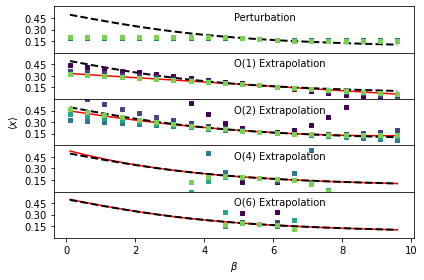

In [11]:
fig, ax = plt.subplots(len(orders)+1, sharex=True, sharey=True)

nsampvals = np.array((10.0*np.ones(5))**np.arange(1,6), dtype=int)
nsampcolors = plt.cm.viridis(np.arange(0.0, 1.0, float(1.0/len(nsampvals))))

#First plot the analytical result
for a in ax:
    a.plot(betas, idealgas.x_ave(betas, vol), 'k--', linewidth=2.0)

#Next look at extrapolation with an infinite number of samples
#This is possible in the ideal gas model in both temperature and volume
for j, o in enumerate(orders):
    trueExtrap, trueDerivs = idealgas.x_beta_extrap(o, beta_ref, betas, vol)
    ax[j+1].plot(betas, trueExtrap, 'r-', zorder=0)
    if j == len(orders)-1:
        print('True extrapolation coefficients: {}'.format(trueDerivs))

for i, n in enumerate(nsampvals):
    thisinds = np.random.choice(len(xdata), size=n, replace=False)
    
    #Get parameters for extrapolation model with this data by training it - the parameters are the derivatives
    xem = xtrap.beta.factory_extrapmodel(
        beta=beta_ref, 
        data=xtrap.DataCentralMomentsVals.from_vals(
        uv=udata[thisinds], xv=xdata[thisinds], central=True, order=order))
    out = xem.predict(betas, cumsum=True)
    
    
    print('\t With N_configs = {:6}: {}'.format(n, xem.derivs(norm=False).values)) #Have to flatten because observable is 1-D
    for j, o in enumerate(orders):
          out.sel(order=o).plot(ax=ax[j+1], marker='s', ls='None', markersize=4, color=nsampcolors[i], 
                                label='N={}'.format(n))
        
    #And do the same thing for perturbation, but here the parameters are just the data
    xpm = xtrap.beta.factory_perturbmodel(beta_ref, udata[thisinds], xdata[thisinds])  
    xpm.predict(betas).plot(ax=ax[0], marker='s', ls='None', ms=4, color=nsampcolors[i])
          

ax[2].set_ylabel(r'$\langle x \rangle$')
ax[-1].set_xlabel(r'$\beta$')

ax[0].annotate('Perturbation', xy=(0.5, 0.7), xycoords='axes fraction')
for j, o in enumerate(orders):
    ax[j+1].annotate('O(%i) Extrapolation'%(o), xy=(0.5, 0.7), xycoords='axes fraction')

ax[-1].set_ylim((0.0, 0.6))
ax[-1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, prune='both'))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

for a in ax:
    a.set_title('')

plt.show()

In each of the figures, the true behavior is shown as a black dashed line, the analytical result (infinite sampling) for each order of extrapolation is shown as a red solid line and the results with 10, 100, 1000, ... 100000 randomly sampled configurations are shown with purple (fewer samples) to green (more samples) circles. Perturbation works close to the reference temperature, but saturates far away. With more samples, it works further out, but the increases in accuracy are marginal. First order extrapolation quickly converges to the infinite sampling limit while second order takes more sampling to do so. The actual coefficients at each order of extrapolation are printed below. Since perturbation essentially refuses to provide an estimate past a certain distance in $\beta$, it is not reliable some distance out. Both first and second order extrapolation essentially get lucky here and remain highly accurate over very large temperature ranges. For higher order extrapolation, the analytical, infinite sampling result matches very closely with the true temperature dependence of $\langle x \rangle$. However, the finite-sampling results are in practice very poor due to difficulties in accurately estimating the higher-order moments of the potential energy distribution. The higher orders are actually quite accurate (if you try zooming in) close to the point we're extrapolating from, but the error grows very quickly as we move further away.